# 量身定制的约束、变量和目标

由于通过 optlang 数学建模包使用符号表达式，因此添加新的变量、约束和高级目标相对简单，这些变量、约束和高级目标不能轻易地表述为不同反应及其相应上限和下限的组合。在这里，我们演示了这个通过 `model.solver.interface`公开的 optlang 功能。

## 约束

假设我们想确保两个反应在模型中有相同的通量。我们可以使用optlang求解器接口将这些标准作为约束添加到模型中，方法是简单地定义相关表达式，如下所示。

In [1]:
from cobra.io import load_model
model = load_model('textbook')

In [2]:
same_flux = model.problem.Constraint(
    model.reactions.FBA.flux_expression - model.reactions.NH4t.flux_expression,
    lb=0,
    ub=0)
model.add_cons_vars(same_flux)

我们感兴趣的反应的通量由`model.reactions.FBA.flux_expression`获得，它只是正向和反向通量的总和，即，

In [3]:
model.reactions.FBA.flux_expression

1.0*FBA - 1.0*FBA_reverse_84806

现在我可以最大限度地提高生长速度，而反应“FBA”和“NH4t”的通量被限制为(接近)相同。

In [4]:
solution = model.optimize()
print(solution.fluxes['FBA'], solution.fluxes['NH4t'],
      solution.objective_value)

4.662749047738146 4.662749047738147 0.8551109609261567


也可以一次添加许多约束。对于大型模型，约束涉及许多反应，有效的方法是首先为每个通量构建线性系数字典，然后立即添加约束。例如，假设我们想对网络中每个通量的绝对值之和添加一个约束，使其小于 100：

In [5]:
coefficients = dict()
for rxn in model.reactions:
    coefficients[rxn.forward_variable] = 1.
    coefficients[rxn.reverse_variable] = 1.
constraint = model.problem.Constraint(0, lb=0, ub=100)
model.add_cons_vars(constraint)
model.solver.update()
constraint.set_linear_coefficients(coefficients=coefficients)

## 对象

简单的目标，例如通过一个或多个反应使通量最大化，只需简单即可完成赋值给 `model.objective`属性，正如我们在前几章中看到的那样，例如，

In [6]:
model = load_model('textbook')
with model:
    model.objective = {model.reactions.Biomass_Ecoli_core: 1}
    model.optimize()
    print(model.reactions.Biomass_Ecoli_core.flux)

0.8739215069684279


目标数学表达式由下式表示

In [7]:
model.objective.expression

1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba

但是假设我们需要一个更复杂的目标，比如最小化解到原点的欧氏距离减去另一个变量，同时受到额外的线性约束。这是一个同时具有线性和二次分量的目标函数。

考虑示例问题：

> **min** $\frac{1}{2}\left(x^2 + y^2 \right) - y$

> *subject to*

> $x + y = 2$

> $x \ge 0$

> $y \ge 0$

这个（确实人为设定得有些过头）的问题，可以用图形的方式来形象化展示，就好比在一系列可行解决方案构成的直线上，用一个蓝点来标记出最佳解。

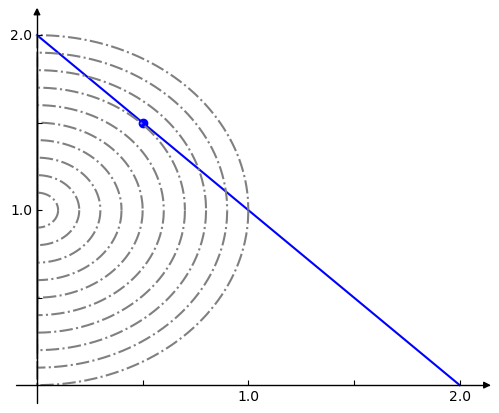

In [8]:
%matplotlib inline
import plot_helper

plot_helper.plot_qp2()

我们回到教科书模型，并将求解器设置为可以处理二次目标(如complex)的求解器。然后我们加上线性约束x和y反应的和，我们设为FBA和NH4t，必须等于2。

In [10]:
import optlang
model.solver = 'cplex'
sum_two = model.problem.Constraint(
    model.reactions.FBA.flux_expression + model.reactions.NH4t.flux_expression,
    lb=2,
    ub=2)
model.add_cons_vars(sum_two)

SolverNotFound: cplex is not a valid solver interface. Pick one from glpk_exact, glpk, scipy.

接下来我们添加二次目标

In [15]:
quadratic_objective = model.problem.Objective(
    0.5 * model.reactions.NH4t.flux_expression**2 + 0.5 *
    model.reactions.FBA.flux_expression**2 -
    model.reactions.FBA.flux_expression,
    direction='min')
model.objective = quadratic_objective
solution = model.optimize(objective_sense=None)

AttributeError: 'SwigPyObject' object has no attribute 'Objective'

In [16]:
print(solution.fluxes['NH4t'], solution.fluxes['FBA'])

4.662749047738147 4.662749047738146


## 变量

我们还可以创建额外的变量，以方便研究新的约束和变量的影响。假设我们想研究氮和碳吸收之间的通量差异，同时我们阻止其他反应。为此，添加另一个表示这种差异的变量可能会有所帮助。

In [11]:
model = load_model('textbook')
difference = model.problem.Variable('difference')

我们使用约束来定义这个变量应采用什么值

In [12]:
constraint = model.problem.Constraint(
    model.reactions.EX_glc__D_e.flux_expression -
    model.reactions.EX_nh4_e.flux_expression - difference,
    lb=0,
    ub=0)
model.add_cons_vars([difference, constraint])

现在，我们可以通过查看其原始值，在敲除探索期间直接访问该差异。

In [13]:
for reaction in model.reactions[:5]:
    with model:
        reaction.knock_out()
        model.optimize()
        print(model.solver.variables.difference.primal)

-5.234680806802557
-5.234680806802542
-5.234680806802542
-10.000000000000028
-10.0
